# Graph Analyses
Here, we'll perform various analysis by constructing graphs and measure properties of those graphs to learn more about the data

In [1]:
import csv
from scipy.spatial import Delaunay
import numpy as np
import math
import skimage
import matplotlib.pyplot as plt
import seaborn as sns
from skimage import future
import networkx as nx
%matplotlib inline

In [2]:
# Read in the data
data = open('../data/data.csv', 'r').readlines()
fieldnames = ['x', 'y', 'z', 'unmasked', 'synapses']
reader = csv.reader(data)
reader.next()

rows = [[int(col) for col in row] for row in reader]

# These will come in handy later
sorted_x = sorted(list(set([r[0] for r in rows])))
sorted_y = sorted(list(set([r[1] for r in rows])))
sorted_z = sorted(list(set([r[2] for r in rows])))

We'll start with just looking at analysis in euclidian space, then thinking about weighing by synaptic density later. Since we hypothesize that our data will show that tissue varies as we move down the y-axis (z-axis in brain) through cortical layers, an interesting thing to do would be compare properties of the graphs on each layer (ie how does graph connectivity vary as we move through layers).

Let's start by triangulating our data. We'll use Delaunay on each y layer first. Putting our data in the right format for doing graph analysis...

In [3]:
a = np.array(rows)
b = np.delete(a, np.s_[3::],1)

# Separate layers - have to do some wonky stuff to get this to work
b = sorted(b, key=lambda e: e[1])
b = np.array([v.tolist() for v in b])
b = np.split(b, np.where(np.diff(b[:,1]))[0]+1)

Now that our data is in the right format, we'll create 52 delaunay graphs. Then we'll perform analyses on these graphs. A simple but useful metric would be to analyze edge length distributions in each layer.

In [4]:
graphs = []
centroid_list = []

for layer in b:
    centroids = np.array(layer)
    
    # get rid of the y value - not relevant anymore
    centroids = np.delete(centroids, 1, 1)
    centroid_list.append(centroids)
    
    graph = Delaunay(centroids)
    graphs.append(graph)

We're going to need a method to get edge lengths from 2D centroid pairs

In [5]:
def get_d_edge_length(edge):
    (x1, y1), (x2, y2) = edge
    return math.sqrt((x2-x1)**2 + (y2-y1)**2)

In [6]:
edge_length_list = [[]]
tri_area_list = [[]]

for del_graph in graphs:
    
    tri_areas = []
    edge_lengths = []
    triangles = []

    for t in centroids[del_graph.simplices]:
        triangles.append(t)
        a, b, c = [tuple(map(int,list(v))) for v in t]
        edge_lengths.append(get_d_edge_length((a,b)))
        edge_lengths.append(get_d_edge_length((a,c)))
        edge_lengths.append(get_d_edge_length((b,c)))
        try:
            tri_areas.append(float(Triangle(a,b,c).area))
        except:
            continue
    edge_length_list.append(edge_lengths)
    tri_area_list.append(tri_areas)

Realizing after all this that simply location is useless. We know the voxels are evenly spaced, which means our edge length data will be all the same. See that the "centroids" are no different:

In [7]:
np.subtract(centroid_list[0], centroid_list[1])

array([[0, 0],
       [0, 0],
       [0, 0],
       ..., 
       [0, 0],
       [0, 0],
       [0, 0]])

There is no distance between the two. Therefore it is perhaps more useful to consider a graph that considers node weights. Voronoi is dual to Delaunay, so that's not much of an option. We want something that considers both spacial location and density similarity. 

## Region Adjacency Graph (RAG)

In the past we've considered density information alone (ie analysis density histogram distribution) and above we are considering only spacial information, which totally doesn't say anything. To construct a graph that consider both spacial and density information, we'll use a Region Adjacency Graph (RAG).

In RAGs, two nodes are considered as neighbor if they are close in proximity (separated by a small number of pixels/voxels) in the horizontal or vertical direction.

<img src="../docs/figures/plot_rag_1.png" width="400">

Since our data includes density values at each node (voxel, or pixel since we're looking at y-layers), we can weight by the inverse of density difference between two nodes. Inverse because strongly connected nodes should be close in weight.

We have number of synapses S<sub>i</sub> at nodes $i$ and define weights $w$ between the nodes:

$$w = \dfrac{1}{S_i - S_{i+1}}$$

RAGs are used largely in image processing, and it makes sense for our data to look more like an image. Since the data is evenly spaced, the absolute locations of the voxels don't matter. We can use the index in the matrix to represent spacial location, with the value at each pixel being the synapse density at that voxel. We've done this before in "real volume"

In [8]:
real_volume = np.zeros((len(sorted_y), len(sorted_x), len(sorted_z)))
for r in rows:
    real_volume[sorted_y.index(r[1]), sorted_x.index(r[0]), sorted_z.index(r[2])] = r[-1]

In [9]:
np.shape(real_volume)

(52, 108, 11)

### Handrolling Own RAG generator

In [10]:
# point = tuple containing index of point (position)
# returns list of neighbors in [north, east, south, west]
def get_neighbors(point, image):
    shape = np.shape(image)
    neighbors = []
    
    # North
    neighbors.append((point[0], point[1]-1)) if point[1]>0 else neighbors.append(None)
    # East
    neighbors.append((point[0]+1, point[1])) if point[0]<shape[0]-1 else neighbors.append(None)
    # South
    neighbors.append((point[0], point[1]+1)) if point[1]<shape[1]-1 else neighbors.append(None)
    # West
    neighbors.append((point[0]-1, point[1])) if point[0]>0 else neighbors.append(None)

    return neighbors

In [11]:
# calculates weights between nodes
# weight defined as inverse absolute distance
def get_weights(image, point, neighbors):
    weights = []
    for neigh in neighbors:
        if neigh != None:
            weight = 1/(abs(image[point] - image[neigh])+1)
            weights.append(weight)
    return weights

In [12]:
image = real_volume[1]
# print image
point = (1,1)
neighbors = get_neighbors(point, image)
# print neighbors

ws = get_weights(image, point, neighbors)

In [13]:
def populate_graph(G, im):
    nodes_to_add = []
    for x in range(np.shape(im)[0]):
        for y in range(np.shape(im)[1]):
            nodes_to_add.append((x,y))
            
    G.add_nodes_from(nodes_to_add)

In [14]:
def generate_rag(im):
    G=nx.Graph()
    
    count = 1
    x = 0
    for col in im:
        y = 0
        for pix in col:
            point = (x,y)
            neighs = get_neighbors(point, im)
            weights = get_weights(im, point, neighs)
#             print point
#             print neighs
            
            to_add = []
            which = 0
            for neigh in neighs:
                if neigh != None:
                    to_add.append((point, neigh, weights[which]))
                    which+=1
#             print to_add
            G.add_weighted_edges_from(to_add)
            y+=1
        x+=1

    return G

### Testing the RAG generator

In [15]:
test_im = real_volume[1]
shape = np.shape(test_im)

ragu = generate_rag(test_im)
ragu.number_of_edges()
# ragu.adjacency_list()

2257

### Creating RAGs for each layer

In [16]:
y_rags = []
for layer in real_volume:
    y_rags.append(generate_rag(layer))

OK, great! Now we have a list of 52 region adjacency graphs for each y-layer. Now we want to measure properties of those graphs and see how the properties vary in the y direction - through what we hypothesize are the cortical layers.

### Number of Edges

This is just a sanity check. They should all be the same if we did it right!

In [17]:
num_edges = []
for rag in y_rags:
    num_edges.append(rag.number_of_edges())

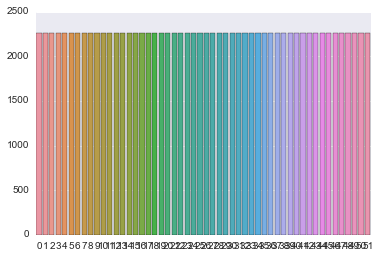

In [18]:
sns.barplot(x=range(len(num_edges)), y=num_edges)
sns.plt.show()

### Drawing Graphs

First we look at the default networkx graph plotting:

We're gonna need to massage the drawing function a bit in order to get the custom positional graph to work.

In [19]:
# for rag in y_rags:
#     plt.figure()
#     nx.draw(rag, node_size=100)

This is using the spring layout, so we're losing positional information. We can improve the plot by adding position information.

## Edge Weight Stats

In [54]:
def get_edge_weight_distributions(rags):
    distributions = []
    for rag in rags:    
        itty = rag.edges_iter()
        weight_list = []
        for index in range(rag.number_of_edges()):
            eddy = itty.next()
            weight_list.append(rag.get_edge_data(eddy[0], eddy[1])['weight'])

        distributions.append(weight_list)
    return distributions

### Mean edge weights

In [55]:
distributions = edge_weight_distributions(y_rags)
y_edge_means = []
for distrib in distributions:
    y_edge_means.append(np.mean(distrib)) 

print y_edge_means

[0.10501648874250402, 0.10743571509781177, 0.10568182717218411, 0.10988087928284998, 0.11590397465016081, 0.11246122919873588, 0.11485929379180491, 0.11456551252541584, 0.12156640683262594, 0.11748959024683463, 0.12072221702876416, 0.1137018527453538, 0.1189136300806812, 0.12008632471187597, 0.12932244434521878, 0.12463361564237359, 0.12273357109341294, 0.11697160082209006, 0.12175928489098203, 0.12182228094722765, 0.12158566453651232, 0.12524643463543825, 0.12333937717531704, 0.12236203720308468, 0.1187563830456604, 0.12239368250281231, 0.12305440274024822, 0.12939721703977924, 0.13274211346023498, 0.12569975501010047, 0.12746472310105184, 0.13644610140476005, 0.13367126278088404, 0.13657732402612346, 0.13262544485116734, 0.14277353929668229, 0.14097032695935344, 0.13713445225890403, 0.13426619198530254, 0.13962907390882798, 0.14834301735559605, 0.16872561668989822, 0.23251120208207979, 0.32237638839867477, 0.42455590547698546, 0.53163149776409724, 0.64479150545415431, 0.7881001338115

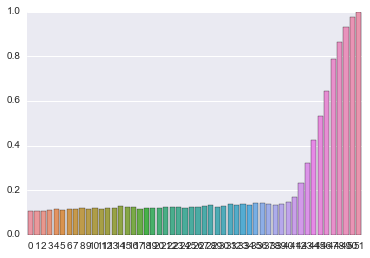

In [59]:
sns.barplot(x=range(len(y_edge_means)), y=y_edge_means)
sns.plt.show()

### Edge Weight Variances

In [58]:
distributions = edge_weight_distributions(y_rags)
y_edge_vars = []
for distrib in distributions:
    y_edge_vars.append(np.var(distrib)) 

print y_edge_vars

[0.049322488297166837, 0.051444747588595706, 0.050466114387521244, 0.051313255988423193, 0.055381987980453934, 0.052346530771570282, 0.055224107346593908, 0.052790456002777236, 0.058659617683281852, 0.054881333732518092, 0.056921127928881037, 0.056145596800809897, 0.059769954092695976, 0.060279787134759878, 0.063173738669354829, 0.062528164084126578, 0.063039397892883473, 0.059008606394821479, 0.061413393834366892, 0.060113350404495884, 0.058617586120866476, 0.059425836332872441, 0.058634009638030539, 0.059006898512948741, 0.058082138221273831, 0.060929829794436847, 0.058816152274400041, 0.062899873117923291, 0.063716511007367027, 0.062227171289963058, 0.062651568754057557, 0.068691956382982644, 0.064524943903893323, 0.068079171811549696, 0.066223736691528076, 0.071880796270675965, 0.071253198809854312, 0.068832732327527374, 0.065249667631763875, 0.069625114595978796, 0.075230385935253927, 0.084690952288985044, 0.12498354816050329, 0.1681672423305543, 0.19922267869337895, 0.20900995764

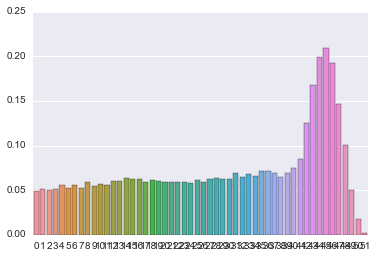

In [60]:
sns.barplot(x=range(len(y_edge_vars)), y=y_edge_vars)
sns.plt.show()

### Number of Self Loops

In [83]:
num_self_loops = []
for rag in y_rags:
    num_self_loops.append(rag.number_of_selfloops())

In [ ]:
num_self_loops

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0]

Interesting. There are no self loops. Why would this be? Let's come back to this. In the meantime, I want to give some though to what it means to have a self loop, whether it should be theoretically possible given our data, and whether our graphs are formed properly.

The answer to this question is very simple. In a RAG, there are no self-loops by definition. Self loops are edges that form a connection between a node and itself.

<img src="../docs/figures/selfloop.png" width="100">

To see whether the graphs are formed properly, let's look at an adjacency lists:

In [18]:
# y_rags[0].adjacency_list()

Compare that to the test data:

In [19]:
# Test Data
test = np.array([[1,2],[3,4]])
test_rag = skimage.future.graph.RAG(test)
test_rag.adjacency_list()

[[2, 3], [1, 4], [1, 4], [2, 3]]

### X-Layers

In [20]:
real_volume_x = np.zeros((len(sorted_x), len(sorted_y), len(sorted_z)))
for r in rows:
    real_volume_x[ sorted_x.index(r[0]), sorted_y.index(r[1]), sorted_z.index(r[2])] = r[-1]

In [21]:
x_rags = []
count = 0;
for layer in real_volume_x:
    count = count + 1
    x_rags.append(skimage.future.graph.RAG(layer))

In [22]:
num_edges_x = []
for rag in x_rags:
    num_edges_x.append(rag.number_of_edges())

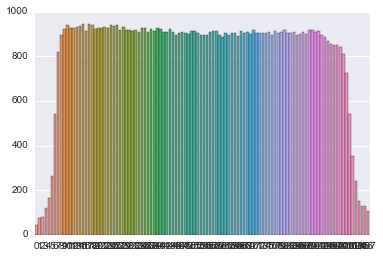

In [23]:
sns.barplot(x=range(len(num_edges_x)), y=num_edges_x)
sns.plt.show()

We can see here the number of edges is low in that area that does not have many synapses. It, as expected, mirrors the distribution of synapses. It appears to be approximately uniform at the top, with buffers of very few synapses on the sides. Remember from here:

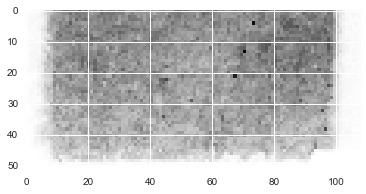

In [24]:
plt.imshow(np.amax(real_volume, axis=2), interpolation='nearest')
plt.show()

In [25]:
# edge_length_list[3]
# tri_area_list[3]
# triangles

In [26]:
# Note for future
# del_features['d_edge_length_mean'] = np.mean(edge_lengths)
# del_features['d_edge_length_std'] = np.std(edge_lengths)
# del_features['d_edge_length_skew'] = scipy.stats.skew(edge_lengths)
# del_features['d_edge_length_kurtosis'] = scipy.stats.kurtosis(edge_lengths)